<a href="https://colab.research.google.com/github/flatplanet/Pytorch-Tutorial-Youtube/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Convert MNIST Image Files into a Tensor of 4-Dimensions (# of images, Height, Width, Color Channels)
transform = transforms.ToTensor()

In [7]:
# Train Data loading
#since data file ./cnn_data is already downloaded, set download = False
train_data = datasets.MNIST(root='./cnn_data', train=True, download=True, transform=transform)

In [9]:
# Test Data loading
test_data = datasets.MNIST(root='./cnn_data', train=False, download=True, transform=transform)

In [11]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [13]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

__Training data has 60000 images__ <br>
__Testing data has 10000 images__

In [17]:
# Create a small batch size for images...let's say 10
#Batch size = 10 images per batch
#Total batches = 60000/10 = 6000
#torch DataLoader stores images as tensor

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [19]:
# Define Our CNN Model
# Describe convolutional layer and what it's doing (2 convolutional layers)
# This is just an example in the next video we'll build out the actual model
#nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
#For gray scale image input_channel =1, for colored RGB image input_channel = 3
"""
out_channels=6

    Number of output channels, or feature maps.

    This means the layer will learn 6 different filters, each detecting different features.

    The output of this layer will have shape: (batch_size, 6, H_out, W_out)
stride=1
        How many pixels the filter moves at each step.

        A stride of 1 means the filter moves one pixel at a time (no skipping).

If your input image is 28x28 (like MNIST), and you're using:
    kernel_size=3

    stride=1

    padding=0

Then the output size becomes:
Output size=(28−3+2∗0)/1+1=26

So the output shape = (batch_size, 6, 26, 26)
"""
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)


In [21]:
# Grab 1 MNIST record/image
for i, (X_Train, y_train) in enumerate(train_data):
  break

In [23]:
X_Train.shape

torch.Size([1, 28, 28])

In [34]:
x = X_Train.view(1,1,28,28)
#.view(N,C,H,W), where N = number of images in batch, C=inp channel (1 for grayscale), Height of images, width of images
#MNIST data are grayscale images with 28x28 pixel size
#.view reshapes the tensor to the shape (N,C,H,W)
#the format is needed when feeding data into CNN

In [36]:
# Perform our first convolution
x = F.relu(conv1(x)) # Rectified Linear Unit for our activation function

In [38]:
# 1 single image, 6 is the filters we asked for, 26x26
x.shape

torch.Size([1, 6, 26, 26])

In [40]:
# pass thru the pooling layer
x = F.max_pool2d(x,2,2) # kernal of 2 and stride of 2

In [42]:
x.shape # 26 / 2 = 13

torch.Size([1, 6, 13, 13])

In [44]:
# Do our second convolutional layer
x = F.relu(conv2(x))

In [46]:
x.shape # Again, we didn't set padding so we lose 2 pixles around the outside of the image

torch.Size([1, 16, 11, 11])

In [48]:
# Pooling layer
x = F.max_pool2d(x,2,2)

In [50]:
x.shape # 11 / 2 = 5.5 but we have to round down, because you can't invent data to round up

torch.Size([1, 16, 5, 5])

In [54]:
((28-2) / 2 - 2) / 2

5.5

In [25]:
"""
self.fc1 = nn.Linear(5*5*16, 120)

    This is the first fully connected layer.

    You're flattening the 3D feature maps from conv2's output to a 1D vector.
    5×5×16=400 features
    5×5×16=400 features

    This layer maps 400 input features to 120 outputs.
Summary of flow:
Input:        (1, 28, 28)
conv1:        (6, 26, 26)
MaxPool:      (6, 13, 13)
conv2:        (16, 11, 11)
MaxPool:      (16, 5, 5)
Flatten:      400
fc1:          120
"""
# Model Class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1) #This layer scans over the input image and extracts 6 different low-level features, such as edges and corners.
    self.conv2 = nn.Conv2d(6,16,3,1) #This further processes the 6-channel output from conv1, learning 16 more abstract features from combinations of the previous ones.
    # Fully Connected Layer
    self.fc1 = nn.Linear(5*5*16, 120) #5*5*16--output of conv2
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10) #last layer has 10 as classification is of 0 - 9 digits

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2) # 2x2 kernal and stride 2
    # Second Pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2) # 2x2 kernal and stride 2

    # Re-View to flatten it out
    X = X.view(-1, 16*5*5) # negative one so that we can vary the batch size

    # Fully Connected Layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1)
      

In [27]:
# Create an Instance of our Model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [29]:
# Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Smaller the Learning Rate, longer its gonna take to train.

In [49]:
"""
torch.max(y_pred.data, 1) returns a tuple:

The max values (not used here)

The indices of those max values — i.e., the predicted class for each sample.

[1] extracts the class indices.

Shape: predicted is a tensor of shape (batch_size,), with the predicted class label for each image.


y_pred is the output of the forward pass through your neural network.
If you're doing image classification (like on MNIST), and:
Your batch size = N
You have 10 output classes (digits 0 through 9)
y_pred.shape  -->  torch.Size([N, 10])
Each row of y_pred is a vector of raw scores (logits) for the 10 classes. So for a single image, the output might look like:
tensor([1.2, -0.8, 0.3, 2.1, 0.5, -1.1, 0.0, 0.9, -0.4, 0.7])
The index of the highest value in this vector is the predicted class.
If you're using CrossEntropyLoss, you can pass y_pred directly to the loss function.
To get actual predicted class labels:
_, predicted = torch.max(y_pred, 1)
"""
import time
start_time = time.time()

# Create Variables To Tracks Things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For Loop of Epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0


  # Train
  for b,(X_train, y_train) in enumerate(train_loader):
    b+=1 # start our batches at 1
    y_pred = model(X_train) # this gives a and output of (N,#o/p classes), where each row has the probability value for that class

    # how off are we? Compare the predictions to correct answers in y_train. o/p is of type tensor(0.85, grad_fn=<NllLossBackward>)
    #This 0.85 means the model's predictions are moderately off from the true labels.
    loss = criterion(y_pred, y_train) 
      
    #print('y_pred,y_pred.shape,loss.shape',y_pred,y_pred.shape,loss)
    predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions. Indexed off the first point, tensor of size #o/p class
    batch_corr = (predicted == y_train).sum() # how many we got correct from this batch. True = 1, False=0, sum those up
    trn_corr += batch_corr # keep track as we go along in training.
    #print('predicted,y_train',predicted,y_train)
    #print('predicted.size(),y_train.size',predicted.size(),y_train.size())
    # Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #tr = ahs
    # Print out some results
    if b%6000 == 0:
      print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)


  # Test
  with torch.no_grad(): #No gradient so we don't update our weights and biases with test data
    for b,(X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] # Adding up correct predictions
      X_Train.view(1,1,28,28)
      tst_corr += (predicted == y_test).sum() # T=1 F=0 and sum away


      loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)



current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')

Epoch: 0  Batch: 6000  Loss: 0.00029827054822817445
Epoch: 1  Batch: 6000  Loss: 1.4790947437286377
Epoch: 2  Batch: 6000  Loss: 0.006457450333982706
Epoch: 3  Batch: 6000  Loss: 0.001380933215841651
Epoch: 4  Batch: 6000  Loss: 0.005783164408057928
Training Took: 3.984310472011566 minutes!


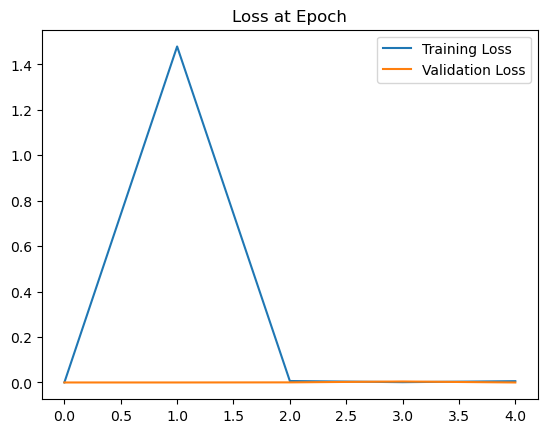

[tensor(0.0003, grad_fn=<NllLossBackward0>), tensor(1.4791, grad_fn=<NllLossBackward0>), tensor(0.0065, grad_fn=<NllLossBackward0>), tensor(0.0014, grad_fn=<NllLossBackward0>), tensor(0.0058, grad_fn=<NllLossBackward0>)] [tensor(4.1445e-05), tensor(3.3076e-05), tensor(0.0005), tensor(0.0044), tensor(5.0306e-06)]


In [53]:
# Graph the loss at epoch
train_losses_list = [tl.item() for tl in train_losses]
plt.plot(train_losses_list, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at Epoch")
plt.legend()
plt.show()

print(train_losses,test_losses)

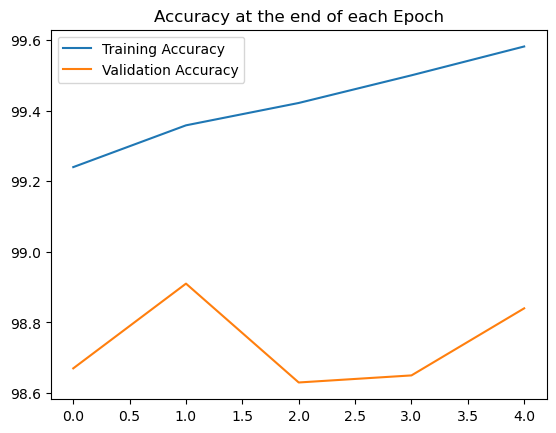

[tensor(59544), tensor(59615), tensor(59653), tensor(59700), tensor(59749)]
[tensor(99.2400), tensor(99.3583), tensor(99.4217), tensor(99.5000), tensor(99.5817)]


In [55]:
# graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label="Training Accuracy")
plt.plot([t/100 for t in test_correct], label="Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()
plt.show()

print(train_correct)
print([t/600 for t in train_correct])

In [ ]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [ ]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [ ]:
# Did for correct
correct.item()/len(test_data)*100

In [ ]:
# Grab an image
test_data[1978] # Tensor with an image in it...at end, it shows the label

In [ ]:
# Grab just the data
test_data[1978][0]

In [ ]:
# Reshape it
test_data[1978][0].reshape(28,28)

In [ ]:
# Show the image
plt.imshow(test_data[1978][0].reshape(28,28))
plt.show()

In [ ]:
# Pass the image thru our model
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[1978][0].view(1,1,28,28)) # batch size of 1, 1 color channel, 28x28 image

In [1]:
# Check the new prediction...get probabilities
new_prediction

NameError: name 'new_prediction' is not defined

In [ ]:
new_prediction.argmax()